In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import torchvision.models as models
from collections import Counter

In [2]:
# 데이터셋 클래스 정의 (이전과 동일)
class MelSpectrogramDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.filepaths = []
        self.labels = []
        self.classes = []

        for file in os.listdir(root_dir):
            if file.endswith('.npy'):
                self.filepaths.append(os.path.join(root_dir, file))
                label = file.split('_')[0]
                if label not in self.classes:
                    self.classes.append(label)
                self.labels.append(self.classes.index(label))

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        file_path = self.filepaths[idx]
        image = np.load(file_path)
        
        # Normalize the image with exception handling
        min_val = image.min()
        max_val = image.max()
        if max_val - min_val != 0:
            image = (image - min_val) / (max_val - min_val)  # Normalize to [0, 1]
        else:
            image = np.zeros_like(image)
        
        image = (image * 255).astype(np.uint8)  # Scale to [0, 255]
        
        image = Image.fromarray(image).convert('RGB')  # Convert to RGB
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
# 데이터 디렉터리 설정 및 클래스 데이터 수 확인
data_dir = 'C:/Users/SSAFY/Desktop/noise_augmented_mel_spectrograms'
filepaths = [file for file in os.listdir(data_dir) if file.endswith('.npy')]
labels = [file.split('_')[0] for file in filepaths]
label_counts = Counter(labels)
print(label_counts)

Counter({'AKM': 1120, 'AUG': 1080, 'SCAR': 1048, 'M762': 856, 'ACE': 836, 'M416': 452})


In [4]:
# 데이터 증강 및 전처리 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
])

In [5]:
# 데이터셋 로드 및 분할
dataset = MelSpectrogramDataset(root_dir=data_dir, transform=transform)

# 데이터셋 분할
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 데이터 로더 생성
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# GunshotClassifier 모델 정의
class GunshotClassifier(nn.Module):
    def __init__(self, num_classes):
        super(GunshotClassifier, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

In [7]:
# 클래스 수 정의
num_classes = len(set(labels))  # 전체 클래스 수 확인
model = GunshotClassifier(num_classes=num_classes)

# 기존 모델 가중치 불러오기
model.load_state_dict(torch.load('fine_tuned_model.pth'))

# 일부 층 고정 (예: ResNet의 feature layers 고정)
for param in model.model.parameters():
    param.requires_grad = False

# 마지막 레이어는 여전히 학습 가능하도록 설정
for param in model.model.fc.parameters():
    param.requires_grad = True

c:\Users\SSAFY\anaconda3\envs\sound\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\SSAFY\anaconda3\envs\sound\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# 모델을 GPU로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 손실 함수 및 옵티마이저 정의
class_weights = torch.tensor([1/label_counts[cls] for cls in sorted(label_counts.keys())], dtype=torch.float)
class_weights = class_weights / class_weights.sum()
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # 전체 모델 파라미터 사용
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # 학습률 스케줄러

In [13]:
# 추가 학습
num_epochs = 70  # 추가 학습 에포크 수
best_accuracy = 0.0
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        progress_bar.set_postfix(loss=running_loss / ((progress_bar.n + 1) * batch_size))

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%')

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'noise_tuned_model.pth')

    scheduler.step()  # 학습률 스케줄러 업데이트

Epoch 1/70: 100%|██████████| 152/152 [00:27<00:00,  5.45it/s, loss=0.537]


Epoch [1/70], Loss: 0.5382, Accuracy: 79.26%


Epoch 2/70: 100%|██████████| 152/152 [00:27<00:00,  5.46it/s, loss=0.543]


Epoch [2/70], Loss: 0.5442, Accuracy: 79.81%


Epoch 3/70: 100%|██████████| 152/152 [00:30<00:00,  5.04it/s, loss=0.538]


Epoch [3/70], Loss: 0.5394, Accuracy: 80.37%


Epoch 4/70: 100%|██████████| 152/152 [00:31<00:00,  4.85it/s, loss=0.531]


Epoch [4/70], Loss: 0.5325, Accuracy: 80.74%


Epoch 5/70: 100%|██████████| 152/152 [00:31<00:00,  4.88it/s, loss=0.544]


Epoch [5/70], Loss: 0.5456, Accuracy: 80.19%


Epoch 6/70: 100%|██████████| 152/152 [00:30<00:00,  4.97it/s, loss=0.537]


Epoch [6/70], Loss: 0.5382, Accuracy: 80.56%


Epoch 7/70: 100%|██████████| 152/152 [00:30<00:00,  4.97it/s, loss=0.55] 


Epoch [7/70], Loss: 0.5514, Accuracy: 79.81%


Epoch 8/70: 100%|██████████| 152/152 [00:31<00:00,  4.90it/s, loss=0.553]


Epoch [8/70], Loss: 0.5542, Accuracy: 79.81%


Epoch 9/70: 100%|██████████| 152/152 [00:30<00:00,  4.94it/s, loss=0.539]


Epoch [9/70], Loss: 0.5398, Accuracy: 79.26%


Epoch 10/70: 100%|██████████| 152/152 [00:30<00:00,  4.97it/s, loss=0.556]


Epoch [10/70], Loss: 0.5574, Accuracy: 80.74%


Epoch 11/70: 100%|██████████| 152/152 [00:30<00:00,  4.92it/s, loss=0.564]


Epoch [11/70], Loss: 0.5655, Accuracy: 80.19%


Epoch 12/70: 100%|██████████| 152/152 [00:30<00:00,  4.91it/s, loss=0.555]


Epoch [12/70], Loss: 0.5568, Accuracy: 79.81%


Epoch 13/70: 100%|██████████| 152/152 [00:30<00:00,  4.96it/s, loss=0.544]


Epoch [13/70], Loss: 0.5457, Accuracy: 80.19%


Epoch 14/70: 100%|██████████| 152/152 [00:30<00:00,  4.94it/s, loss=0.547]


Epoch [14/70], Loss: 0.5483, Accuracy: 80.00%


Epoch 15/70: 100%|██████████| 152/152 [00:31<00:00,  4.88it/s, loss=0.541]


Epoch [15/70], Loss: 0.5420, Accuracy: 79.44%


Epoch 16/70: 100%|██████████| 152/152 [00:30<00:00,  4.91it/s, loss=0.557]


Epoch [16/70], Loss: 0.5580, Accuracy: 79.63%


Epoch 17/70: 100%|██████████| 152/152 [00:30<00:00,  4.91it/s, loss=0.558]


Epoch [17/70], Loss: 0.5591, Accuracy: 80.74%


Epoch 18/70: 100%|██████████| 152/152 [00:31<00:00,  4.88it/s, loss=0.547]


Epoch [18/70], Loss: 0.5485, Accuracy: 80.74%


Epoch 19/70: 100%|██████████| 152/152 [00:30<00:00,  4.96it/s, loss=0.533]


Epoch [19/70], Loss: 0.5344, Accuracy: 79.44%


Epoch 20/70: 100%|██████████| 152/152 [00:30<00:00,  4.94it/s, loss=0.548]


Epoch [20/70], Loss: 0.5492, Accuracy: 79.44%


Epoch 21/70: 100%|██████████| 152/152 [00:30<00:00,  4.91it/s, loss=0.55] 


Epoch [21/70], Loss: 0.5518, Accuracy: 79.44%


Epoch 22/70: 100%|██████████| 152/152 [00:31<00:00,  4.80it/s, loss=0.548]


Epoch [22/70], Loss: 0.5492, Accuracy: 80.19%


Epoch 23/70: 100%|██████████| 152/152 [00:31<00:00,  4.90it/s, loss=0.557]


Epoch [23/70], Loss: 0.5583, Accuracy: 80.56%


Epoch 24/70: 100%|██████████| 152/152 [00:30<00:00,  4.92it/s, loss=0.545]


Epoch [24/70], Loss: 0.5465, Accuracy: 79.81%


Epoch 25/70: 100%|██████████| 152/152 [00:31<00:00,  4.89it/s, loss=0.549]


Epoch [25/70], Loss: 0.5500, Accuracy: 79.44%


Epoch 26/70: 100%|██████████| 152/152 [00:31<00:00,  4.90it/s, loss=0.55] 


Epoch [26/70], Loss: 0.5510, Accuracy: 80.00%


Epoch 27/70: 100%|██████████| 152/152 [00:31<00:00,  4.85it/s, loss=0.54] 


Epoch [27/70], Loss: 0.5416, Accuracy: 80.37%


Epoch 28/70: 100%|██████████| 152/152 [00:31<00:00,  4.90it/s, loss=0.541]


Epoch [28/70], Loss: 0.5423, Accuracy: 79.81%


Epoch 29/70: 100%|██████████| 152/152 [00:30<00:00,  4.92it/s, loss=0.55] 


Epoch [29/70], Loss: 0.5512, Accuracy: 79.26%


Epoch 30/70: 100%|██████████| 152/152 [00:30<00:00,  4.93it/s, loss=0.557]


Epoch [30/70], Loss: 0.5579, Accuracy: 80.56%


Epoch 31/70: 100%|██████████| 152/152 [00:30<00:00,  4.91it/s, loss=0.563]


Epoch [31/70], Loss: 0.5649, Accuracy: 80.74%


Epoch 32/70: 100%|██████████| 152/152 [00:30<00:00,  4.92it/s, loss=0.546]


Epoch [32/70], Loss: 0.5476, Accuracy: 80.19%


Epoch 33/70: 100%|██████████| 152/152 [00:30<00:00,  4.91it/s, loss=0.545]


Epoch [33/70], Loss: 0.5462, Accuracy: 80.37%


Epoch 34/70: 100%|██████████| 152/152 [00:30<00:00,  4.90it/s, loss=0.537]


Epoch [34/70], Loss: 0.5378, Accuracy: 80.93%


Epoch 35/70: 100%|██████████| 152/152 [00:30<00:00,  4.95it/s, loss=0.54] 


Epoch [35/70], Loss: 0.5411, Accuracy: 80.00%


Epoch 36/70: 100%|██████████| 152/152 [00:30<00:00,  4.92it/s, loss=0.556]


Epoch [36/70], Loss: 0.5574, Accuracy: 80.00%


Epoch 37/70: 100%|██████████| 152/152 [00:31<00:00,  4.89it/s, loss=0.543]


Epoch [37/70], Loss: 0.5447, Accuracy: 79.81%


Epoch 38/70: 100%|██████████| 152/152 [00:30<00:00,  4.93it/s, loss=0.547]


Epoch [38/70], Loss: 0.5485, Accuracy: 80.00%


Epoch 39/70: 100%|██████████| 152/152 [00:30<00:00,  4.94it/s, loss=0.553]


Epoch [39/70], Loss: 0.5546, Accuracy: 80.19%


Epoch 40/70: 100%|██████████| 152/152 [00:30<00:00,  4.93it/s, loss=0.549]


Epoch [40/70], Loss: 0.5500, Accuracy: 80.00%


Epoch 41/70: 100%|██████████| 152/152 [00:30<00:00,  4.92it/s, loss=0.561]


Epoch [41/70], Loss: 0.5626, Accuracy: 80.19%


Epoch 42/70: 100%|██████████| 152/152 [00:30<00:00,  4.92it/s, loss=0.55] 


Epoch [42/70], Loss: 0.5514, Accuracy: 79.07%


Epoch 43/70: 100%|██████████| 152/152 [00:31<00:00,  4.90it/s, loss=0.551]


Epoch [43/70], Loss: 0.5525, Accuracy: 80.19%


Epoch 44/70: 100%|██████████| 152/152 [00:31<00:00,  4.87it/s, loss=0.545]


Epoch [44/70], Loss: 0.5467, Accuracy: 79.81%


Epoch 45/70: 100%|██████████| 152/152 [00:32<00:00,  4.74it/s, loss=0.545]


Epoch [45/70], Loss: 0.5461, Accuracy: 80.93%


Epoch 46/70: 100%|██████████| 152/152 [00:30<00:00,  4.92it/s, loss=0.546]


Epoch [46/70], Loss: 0.5471, Accuracy: 80.19%


Epoch 47/70: 100%|██████████| 152/152 [00:30<00:00,  4.92it/s, loss=0.55] 


Epoch [47/70], Loss: 0.5509, Accuracy: 80.37%


Epoch 48/70: 100%|██████████| 152/152 [00:30<00:00,  4.93it/s, loss=0.562]


Epoch [48/70], Loss: 0.5637, Accuracy: 79.81%


Epoch 49/70: 100%|██████████| 152/152 [00:35<00:00,  4.32it/s, loss=0.538]


Epoch [49/70], Loss: 0.5389, Accuracy: 80.56%


Epoch 50/70: 100%|██████████| 152/152 [00:40<00:00,  3.71it/s, loss=0.555]


Epoch [50/70], Loss: 0.5567, Accuracy: 80.19%


Epoch 51/70: 100%|██████████| 152/152 [00:31<00:00,  4.84it/s, loss=0.546]


Epoch [51/70], Loss: 0.5470, Accuracy: 80.93%


Epoch 52/70: 100%|██████████| 152/152 [00:31<00:00,  4.90it/s, loss=0.548]


Epoch [52/70], Loss: 0.5492, Accuracy: 80.19%


Epoch 53/70: 100%|██████████| 152/152 [00:31<00:00,  4.90it/s, loss=0.553]


Epoch [53/70], Loss: 0.5544, Accuracy: 79.63%


Epoch 54/70: 100%|██████████| 152/152 [00:30<00:00,  4.90it/s, loss=0.552]


Epoch [54/70], Loss: 0.5536, Accuracy: 80.74%


Epoch 55/70: 100%|██████████| 152/152 [00:30<00:00,  4.92it/s, loss=0.551]


Epoch [55/70], Loss: 0.5527, Accuracy: 80.37%


Epoch 56/70: 100%|██████████| 152/152 [00:30<00:00,  4.92it/s, loss=0.546]


Epoch [56/70], Loss: 0.5477, Accuracy: 80.74%


Epoch 57/70: 100%|██████████| 152/152 [00:30<00:00,  4.92it/s, loss=0.543]


Epoch [57/70], Loss: 0.5444, Accuracy: 80.19%


Epoch 58/70: 100%|██████████| 152/152 [00:31<00:00,  4.83it/s, loss=0.552]


Epoch [58/70], Loss: 0.5534, Accuracy: 79.44%


Epoch 59/70: 100%|██████████| 152/152 [00:31<00:00,  4.89it/s, loss=0.55] 


Epoch [59/70], Loss: 0.5509, Accuracy: 80.56%


Epoch 60/70: 100%|██████████| 152/152 [00:31<00:00,  4.90it/s, loss=0.543]


Epoch [60/70], Loss: 0.5447, Accuracy: 80.56%


Epoch 61/70: 100%|██████████| 152/152 [00:31<00:00,  4.89it/s, loss=0.549]


Epoch [61/70], Loss: 0.5505, Accuracy: 79.44%


Epoch 62/70: 100%|██████████| 152/152 [00:31<00:00,  4.89it/s, loss=0.545]


Epoch [62/70], Loss: 0.5459, Accuracy: 79.63%


Epoch 63/70: 100%|██████████| 152/152 [00:31<00:00,  4.90it/s, loss=0.561]


Epoch [63/70], Loss: 0.5623, Accuracy: 80.56%


Epoch 64/70: 100%|██████████| 152/152 [00:30<00:00,  4.91it/s, loss=0.57] 


Epoch [64/70], Loss: 0.5709, Accuracy: 79.63%


Epoch 65/70: 100%|██████████| 152/152 [00:31<00:00,  4.89it/s, loss=0.547]


Epoch [65/70], Loss: 0.5488, Accuracy: 79.63%


Epoch 66/70: 100%|██████████| 152/152 [00:31<00:00,  4.87it/s, loss=0.532]


Epoch [66/70], Loss: 0.5338, Accuracy: 79.81%


Epoch 67/70: 100%|██████████| 152/152 [00:31<00:00,  4.89it/s, loss=0.554]


Epoch [67/70], Loss: 0.5557, Accuracy: 80.00%


Epoch 68/70: 100%|██████████| 152/152 [00:31<00:00,  4.87it/s, loss=0.544]


Epoch [68/70], Loss: 0.5450, Accuracy: 81.11%


Epoch 69/70: 100%|██████████| 152/152 [00:31<00:00,  4.88it/s, loss=0.549]


Epoch [69/70], Loss: 0.5499, Accuracy: 80.93%


Epoch 70/70: 100%|██████████| 152/152 [00:31<00:00,  4.88it/s, loss=0.557]


Epoch [70/70], Loss: 0.5583, Accuracy: 81.30%


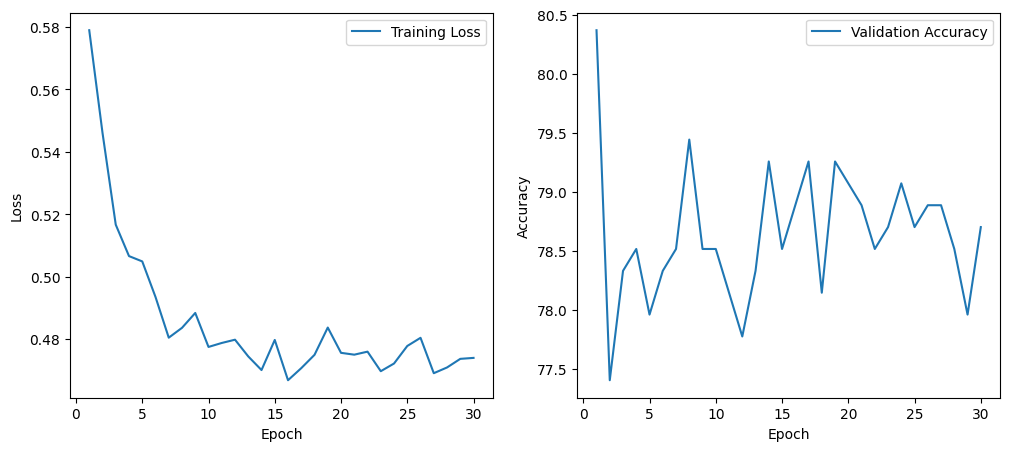

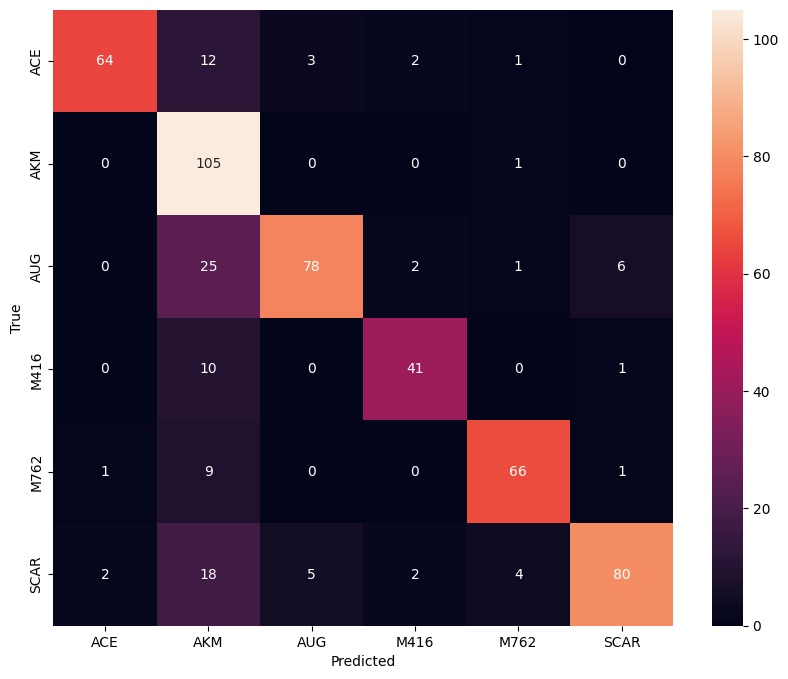

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 학습 손실 및 검증 정확도 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 모델 평가 및 혼동 행렬 생성
model.load_state_dict(torch.load('fine_tuned_model.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=sorted(dataset.classes), yticklabels=sorted(dataset.classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()